# Comparison to the Global Mean Sea Level
We compare the global average TWS of our reconstruction with a TWS reconstruction derived from the global mean sea level (GMSL).

In [1]:
import matplotlib.pyplot as plt
import janitor  # noqa
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec.utils import ROOT_DIR

# Register dask progress bar
ProgressBar(minimum=5).register()

In [2]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "figures/si"

## Data Preprocessing

## Data Loading

Load and combine the different data sets (GRACE, ERA5, WGHM, and our and other reconstructions)

In [3]:
# Load and combine our predictions
pred_dir = ROOT_DIR / "models/predictions/ensemble-mixed"

ours_list = []

for inp_name in ["era", "era-rdcd", "wghm-era"]:
    twsa_ours = xr.open_zarr(pred_dir / f"ensemble-mixed_{inp_name}_best-mae.zarr").twsa
    ours_list.append(twsa_ours.rename(f"twsa_ours_{inp_name}"))
ours = xr.merge(ours_list)


In [4]:
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"
recs_store = ROOT_DIR / "data/processed/reconstructions.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
recs = xr.open_zarr(recs_store)


In [5]:
# Merge all data sets
ds_all = xr.merge([tgts, inps, ours, recs])

# Create and apply mask (land area and Greenland+Antarctica exclusion)
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
ds_all = ds_all.where(mask == 1)

# Substract the GRACE baseline
baseline = slice("2004", "2009")
base_mean = ds_all.sel(time=baseline).mean("time")
ds_all = ds_all - base_mean


Specify variables of interest and their descriptive names:

In [6]:
vars_verbose = {
    "twsa_ours_era": "DeepRec",
    "twsa_ours_wghm-era": "DeepRec, w/ WGHM",
    "twsa_gap": "WGHM",
    "humphrey_gsfc_detrend": "Humphrey's GSFC Rec",
    "li_csr_full": "Li's CSR Rec",
    "yin_csr_full": "Yin's CSR Rec",
    "palazzoli_jpl_full": "Palazzoli's JPL Rec",
}
eval_names = list(vars_verbose.keys())


In [7]:
tws = ds_all[eval_names]

### Calculate the global TWSA mean

In [8]:
# Time stamps where our prediction is available
our_time = ours.dropna("time", how="all").time

In [9]:
tws_mean = (
    tws.sel(time=slice(our_time[0], our_time[-1]), drop=True)
    .dr.weight_lat()
    .mean(["lat", "lon"])
    # Calculate yearly averages
    .groupby("time.year")
    .mean()
    .compute()
)

### Load GMSL Components

In [10]:
df = pd.read_excel(
    ROOT_DIR / "data/raw/inputs/sea-level/frederikse/global_basin_timeseries.xlsx"
)
df = df.rename(columns={df.columns[0]: "year"}).set_index("year")
df.columns = df.columns.str.replace(r"[\[\]]", "", regex=True)
df = df.clean_names()

In [11]:
# But bounds into separate dataframes
df_mean = df[df.columns[df.columns.str.endswith("mean")]]
df_upper = df[df.columns[df.columns.str.endswith("upper")]]
df_lower = df[df.columns[df.columns.str.endswith("lower")]]

df_mean.columns = df_mean.columns.str.replace("_mean", "")
df_upper.columns = df_upper.columns.str.replace("_upper", "")
df_lower.columns = df_lower.columns.str.replace("_lower", "")

### Bounds calculation

Because calculate the variance ($\sigma^2$) from the given lower ($CI_L$) and upper ($CI_U$) confidence intervals:

$$
\sigma^2 = \left(\frac{CI_U - CI_L}{2 \cdot 1.645}\right)^2
$$

Upper and lower bounds are 90 % confidence, which is equal to a Z-score of 1.645.

In [12]:
Z_SCORE = 1.645

# Calculate the variances of each variable
variances = ((df_upper - df_lower) / (2 * Z_SCORE)) ** 2

comps = [
    "steric",
    "greenland_ice_sheet",
    "antarctic_ice_sheet",
    "terrestrial_water_storage",
    "glaciers",
]

# Calculate the variance of the sum of GMSL components
var_summed = variances[comps].sum(axis=1)

Validity check: Calculate the bounds from the sum of all component variances and compare to Frederikse's `sum_of_contributors` bounds:

In [13]:
# Calculate the 90 % CI of the summed components
error_summed = Z_SCORE * np.sqrt(var_summed)
ubound_summed = df_mean.sum_of_contributors + error_summed
lbound_summed = df_mean.sum_of_contributors - error_summed


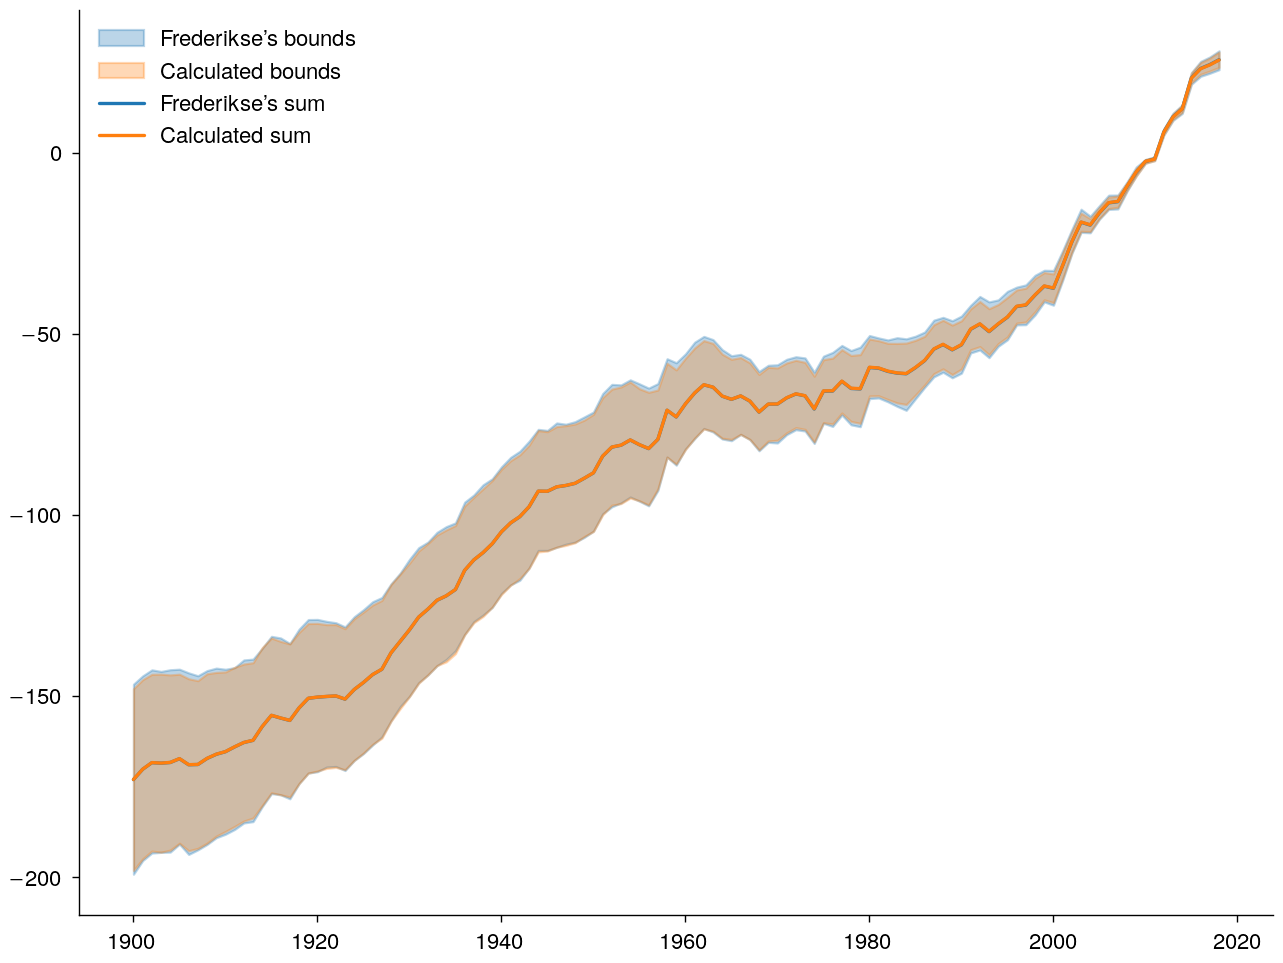

In [14]:
fig, ax = plt.subplots()

ax.fill_between(
    df_mean.index,
    df_lower.sum_of_contributors,
    df_upper.sum_of_contributors,
    alpha=0.3,
    color="tab:blue",
    label="Frederikse's bounds",
)
ax.fill_between(
    df_mean.index,
    ubound_summed,
    lbound_summed,
    alpha=0.3,
    color="tab:orange",
    label="Calculated bounds",
)
ax.plot(df_mean.sum_of_contributors, color="tab:blue", label="Frederikse's sum")
ax.plot(df_mean[comps].sum(axis=1), color="tab:orange", label="Calculated sum")
ax.legend();

The results are almost identical.

### Baseline adjustment

The negative globally averaged TWS on land is equal to the TWS contribution to the GMSL. To use our TWS predictions instead of Frederikse's, we have to make sure all Anomalies have the same baseline mean. We will use the GRACE baseline (2004-2009), contrary to Frederiks who uses 2002 to 2018 as baseline.

In [15]:
# Negate TWS and convert to dataframe
tws_preds = -tws_mean.to_pandas()

baseline = slice(2004, 2009)

# Predictions
preds_base = tws_preds.loc[baseline].mean()
tws_preds = tws_preds - preds_base

# GMSL mean
df_mean_base = df_mean.loc[baseline].mean()
df_mean = df_mean - df_mean_base

# GMSL bounds
df_upper = df_upper - df_mean_base
df_lower = df_lower - df_mean_base

In [16]:
assert np.isclose(tws_preds.loc[baseline].mean(), 0).all()

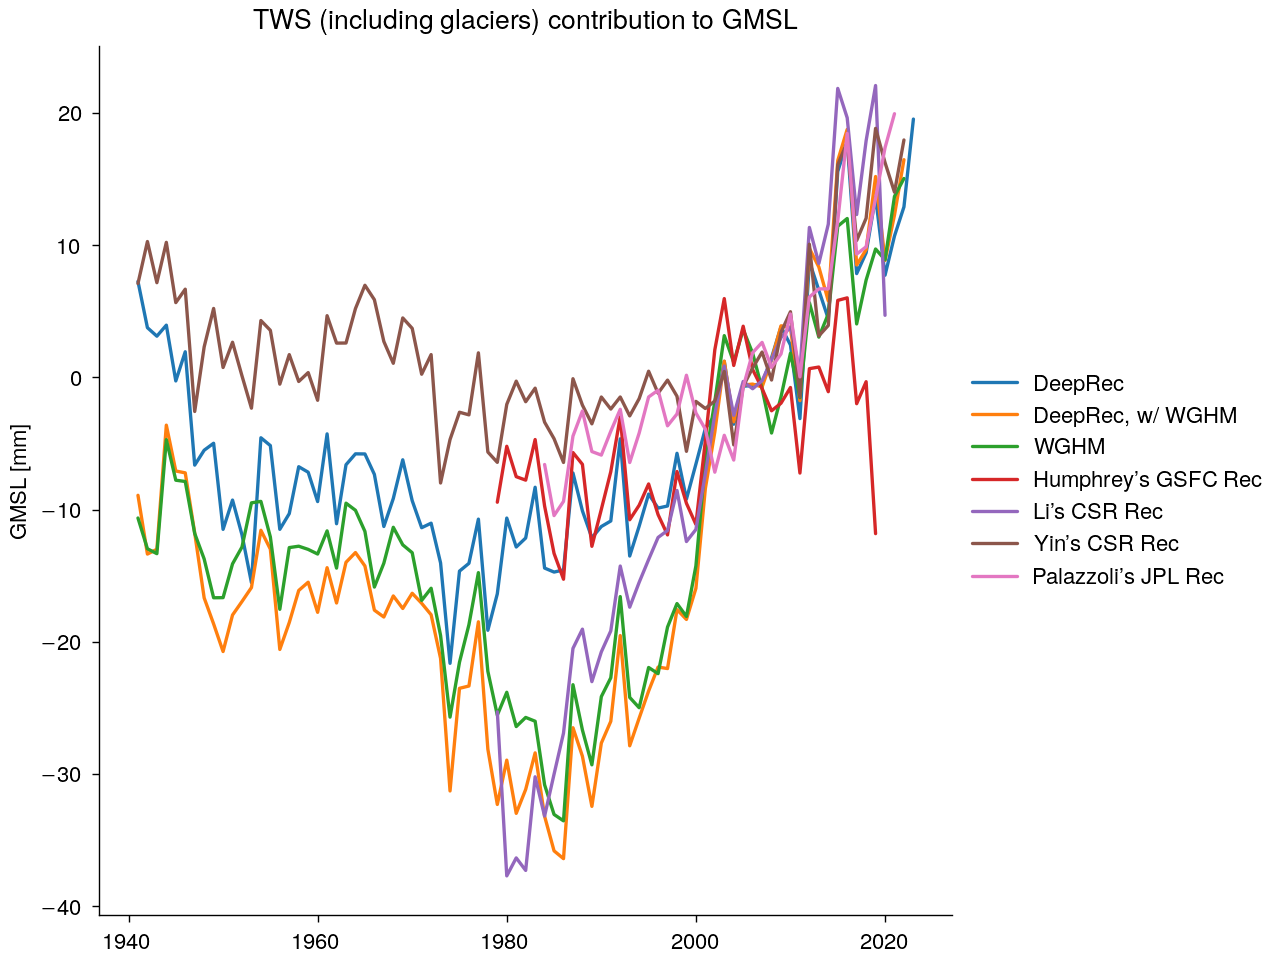

In [17]:
# Plot all TWS predictions
ax = tws_preds.rename(columns=vars_verbose).plot()
ax.set_title("TWS (including glaciers) contribution to GMSL")
ax.set_xlabel(None)
ax.set_ylabel("GMSL [mm]")
ax.legend(loc="lower center")
sns.move_legend(
    ax, loc="center left", bbox_to_anchor=(1, 0.5), title=None, frameon=False
)

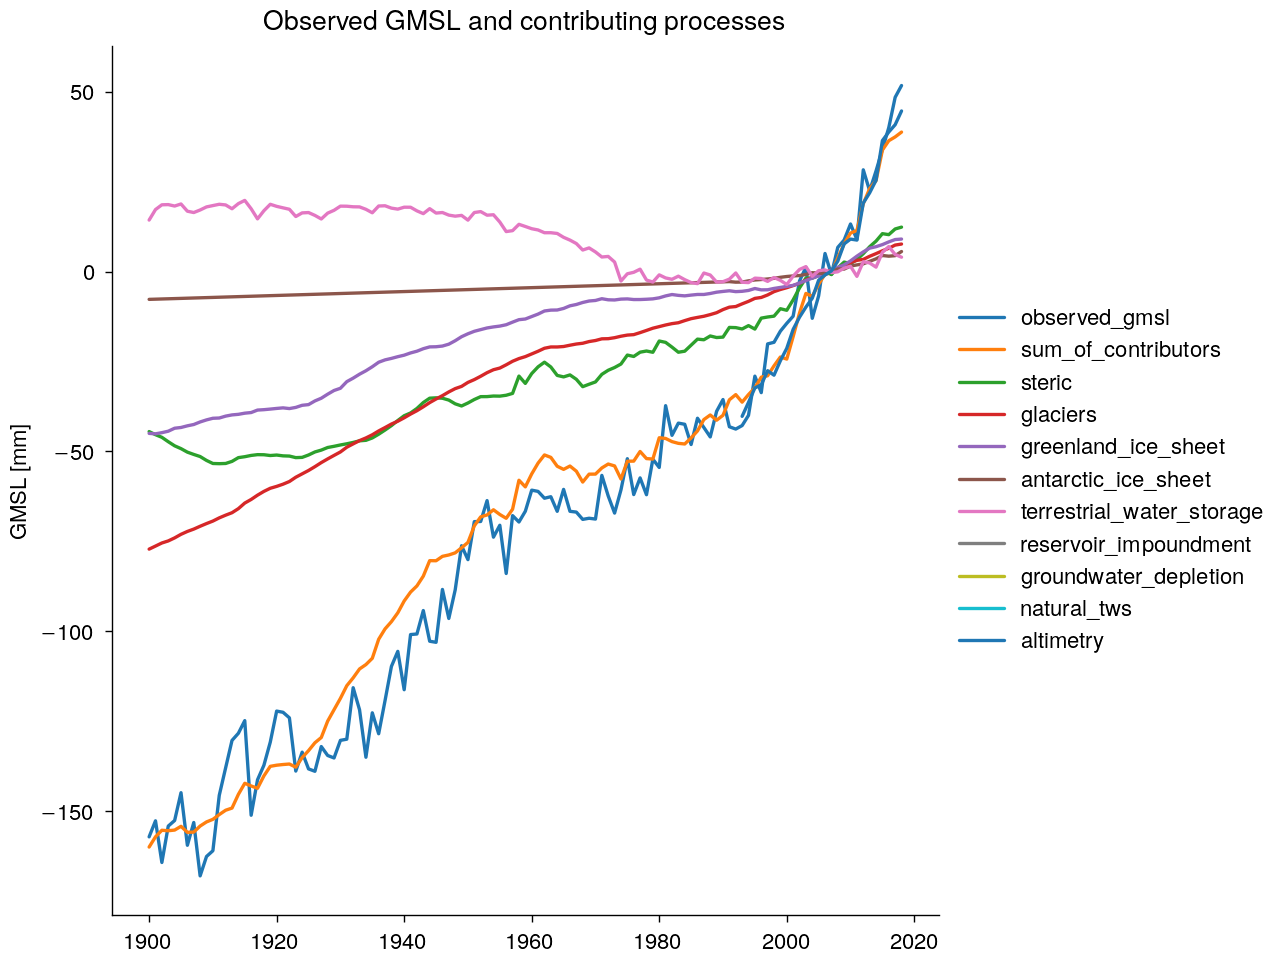

In [18]:
# Plot Frederikse's products
ax = df_mean.plot()
ax.set_title("Observed GMSL and contributing processes")
ax.set_xlabel(None)
ax.set_ylabel("GMSL [mm]")
sns.move_legend(
    ax, loc="center left", bbox_to_anchor=(1, 0.5), title=None, frameon=False
)

## Plot Sea Level Budget Closure

In [19]:
# Calculated the TWSA estimated from GMSL (GMSL observation - est. ice - est. steric) and its variance
obs_tws = (
    df_mean.observed_gmsl
    - df_mean.steric
    - df_mean.greenland_ice_sheet
    - df_mean.antarctic_ice_sheet
)
var_obs_tws = (
    variances.observed_gmsl
    - variances.steric
    - variances.greenland_ice_sheet
    - variances.antarctic_ice_sheet
)
error_obs_tws = Z_SCORE * np.sqrt(var_obs_tws)
ubound_obs_tws = obs_tws + error_obs_tws
lbound_obs_tws = obs_tws - error_obs_tws

# Calculated the estimated TWS (Altimetry - est. ice - est. steric) and its variance
alt_tws = (
    df_mean.altimetry
    - df_mean.steric
    - df_mean.greenland_ice_sheet
    - df_mean.antarctic_ice_sheet
)
var_alt_tws = (
    variances.altimetry
    - variances.steric
    - variances.greenland_ice_sheet
    - variances.antarctic_ice_sheet
)
error_alt_tws = Z_SCORE * np.sqrt(var_alt_tws)
ubound_alt_tws = alt_tws + error_alt_tws
lbound_alt_tws = alt_tws - error_alt_tws

In [20]:
nvars = len(tws_preds.columns)
ncols = 2
nrows = int(np.ceil(nvars / ncols))

subplot_kwargs = dict(
    nrows=nrows, ncols=ncols, figsize=(6, 7), sharex=True, sharey=True
)
colors = sns.color_palette("tab10")


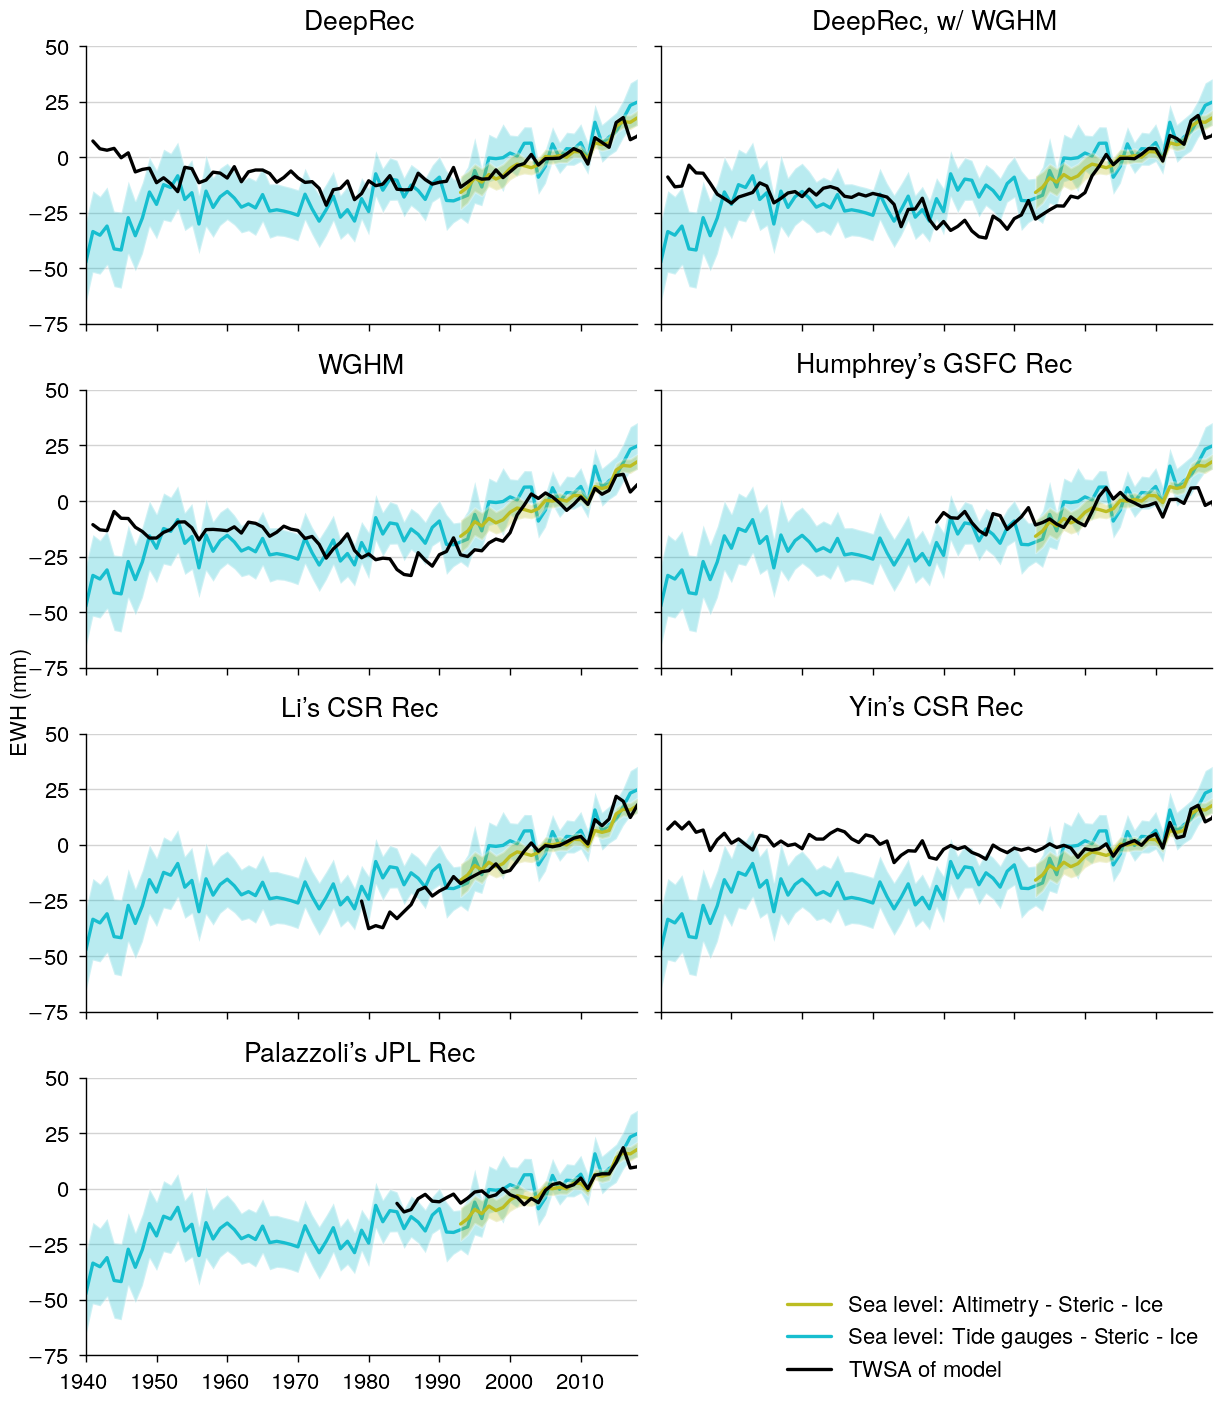

In [21]:
fig, axs = plt.subplots(**subplot_kwargs)

for i, ax, (name, tws_pred) in zip(range(nvars), axs.flat, tws_preds.items()):
    labels = (
        [
            "Sea level: Altimetry - Steric - Ice",
            "Sea level: Tide gauges - Steric - Ice",
            "TWSA of model",
        ]
        if i == 0
        else ["_"] * 3
    )
    # Plot  altimetry
    ax.plot(alt_tws, label=labels[0], color=colors[8], zorder=4)
    ax.fill_between(
        alt_tws.index,
        y1=ubound_alt_tws,
        y2=lbound_alt_tws,
        alpha=0.3,
        facecolor=colors[8],
        zorder=3,
    )
    # Plot estimate from observed
    ax.plot(obs_tws, label=labels[1], color=colors[9], zorder=2)
    ax.fill_between(
        obs_tws.index,
        y1=ubound_obs_tws,
        y2=lbound_obs_tws,
        alpha=0.3,
        facecolor=colors[9],
        zorder=1,
    )

    # Plot reconstruction
    ax.plot(tws_pred, label=labels[2], color="black", zorder=5)
    ax.set_title(vars_verbose[name])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.label_outer()
    ax.set_xlim((1940, 2018))
    # ax.set_ylim((-60, 40))
    ax.set_ylim((-75, 50))
    ax.label_outer()
    ax.yaxis.grid(True)

# Remove empty axis
axs.flat[7].set_axis_off()

fig.legend(loc="lower right", bbox_to_anchor=(1.0, 0.0), title=None)
# fig.legend(loc="outside lower right", title=None)

# Set common labels
fig.text(0.0, 0.5, "EWH (mm)", ha="center", va="center", rotation="vertical")

fig.savefig(FIGURE_DIR / "gmsl_tws_observed.pdf", backend="pgf")

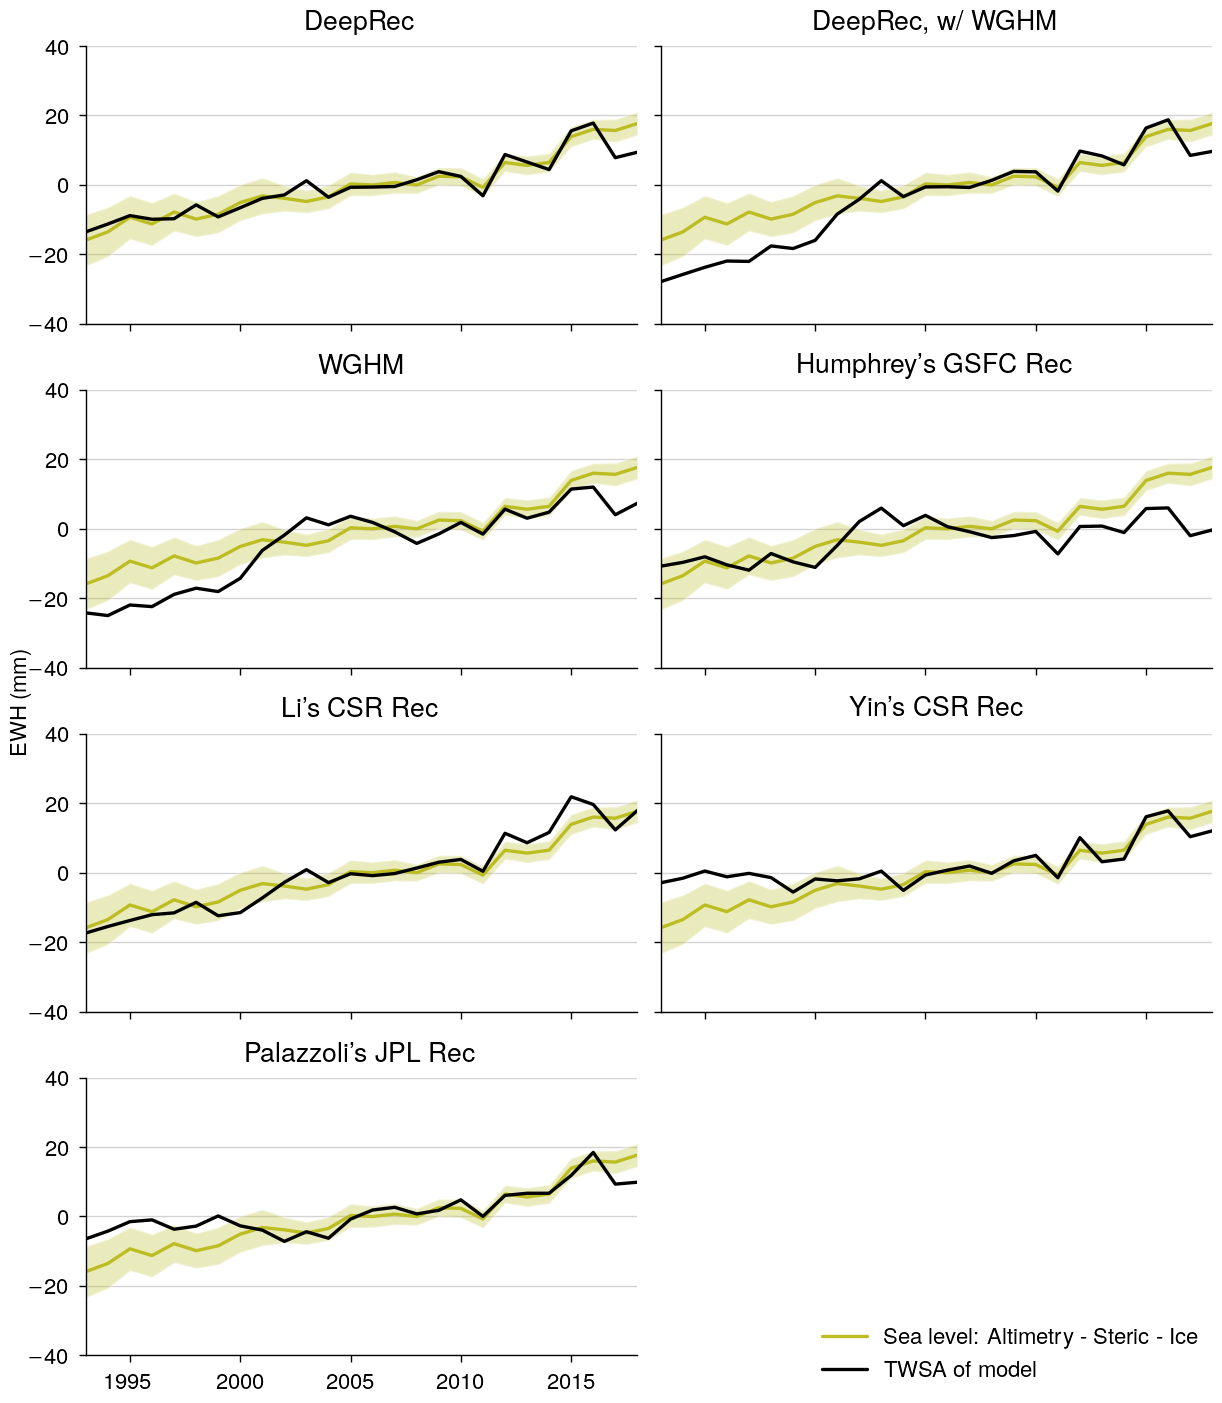

In [ ]:
fig, axs = plt.subplots(**subplot_kwargs)

for i, ax, (name, tws_pred) in zip(range(nvars), axs.flat, tws_preds.items()):
    labels = (
        [
            "Sea level: Altimetry - Steric - Ice",
            "TWSA of model",
        ]
        if i == 0
        else ["_"] * 3
    )
    # Plot altimetry
    ax.plot(alt_tws, label=labels[0], color=colors[8], zorder=2)
    ax.fill_between(
        alt_tws.index,
        y1=ubound_alt_tws,
        y2=lbound_alt_tws,
        alpha=0.3,
        facecolor=colors[8],
        zorder=1,
    )

    # Plot reconstruction
    ax.plot(tws_pred, label=labels[1], color="black", zorder=3)
    ax.set_title(vars_verbose[name])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.label_outer()
    ax.set_xlim((1993, 2018ax.set_ylim((-40, 40))
    ax.yaxis.grid(True)

# Remove empty axis
axs.flat[7].set_axis_off()

fig.legend(loc="lower right", bbox_to_anchor=(1.0, 0.0), title=None)
# fig.legend(loc="outside lower right", title=None)

# Set common labels
fig.text(0.0, 0.5, "EWH (mm)", ha="center", va="center", rotation="vertical")

fig.savefig(FIGURE_DIR / "gmsl_tws_altimetry.pdf", backend="pgf")